In [2]:
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Load Data ===
train_df = pd.read_csv("valorant_train_clean.csv")
test_df = pd.read_csv("valorant_test_clean.csv")

In [3]:
# Attempt to fix/get rid of any NaNs

print("Before fixing any NaNs:")
print(train_df[train_df.isna().any(axis=1)])

print(test_df[test_df.isna().any(axis=1)])

def replace_rows_by_puuid(df_with_nans, backup_dfs):
    """
    Fill NaN values in df_with_nans row-by-row using matching rows from backup_dfs based on 'puuid'.
    Only missing cells are filled; existing values are preserved.

    Args:
        df_with_nans (pd.DataFrame): DataFrame that may contain NaNs.
        backup_dfs (list of pd.DataFrame): Backup DataFrames to search for clean replacement values.

    Returns:
        pd.DataFrame: Cleaned DataFrame with missing values filled.
    """
    df_cleaned = df_with_nans.copy()
    rows_with_nans = df_cleaned[df_cleaned.isna().any(axis=1)]

    for idx, row in rows_with_nans.iterrows():
        puuid = row["puuid"]
        for backup in backup_dfs:
            match = backup[backup["puuid"] == puuid]
            if not match.empty:
                for col in df_cleaned.columns:
                    if pd.isna(df_cleaned.at[idx, col]) and col in match.columns:
                        df_cleaned.at[idx, col] = match.iloc[0][col]
                break  # Stop after first successful match
        else:
            print(f"⚠️ Could not find replacement for PUUID: {puuid}")
    
    return df_cleaned


may15_df = pd.read_csv("valorant_players_processedMay15,2025+morepreprocessing.csv")
may12_df = pd.read_csv("valorant_players_processedMay12,2025wlabels.csv")


train_df = replace_rows_by_puuid(train_df, [may15_df, may12_df])
test_df = replace_rows_by_puuid(test_df, [may15_df, may12_df])

print("After fixing any NaNs:")
# train_df[train_df.isna().any(axis=1)]
print(train_df[train_df.isna().any(axis=1)])
print(test_df[test_df.isna().any(axis=1)])

# full_df[full_df["puuid"] == "003f1ca7-ce96-5bf1-b042-c0da89a3d653"]

# For testing
# train_df = train_df.dropna()
# test_df = test_df.dropna()

Before fixing any NaNs:
Empty DataFrame
Columns: [puuid, user, tag, hs_percent, body_percent, leg_percent, s_damage_per_round, s_kd_ratio, s_hs_percent, s_win_percent, s_kast_percent, s_dd_round, s_acs, s_kad_ratio, s_kills_per_round, deaths_per_game, kills_per_game, assists_per_game, first_bloods_per_game, flawless_rounds_per_game, aces_per_game, smurf_label]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [puuid, user, tag, hs_percent, body_percent, leg_percent, s_damage_per_round, s_kd_ratio, s_hs_percent, s_win_percent, s_kast_percent, s_dd_round, s_acs, s_kad_ratio, s_kills_per_round, deaths_per_game, kills_per_game, assists_per_game, first_bloods_per_game, flawless_rounds_per_game, aces_per_game, smurf_label]
Index: []

[0 rows x 22 columns]
After fixing any NaNs:
Empty DataFrame
Columns: [puuid, user, tag, hs_percent, body_percent, leg_percent, s_damage_per_round, s_kd_ratio, s_hs_percent, s_win_percent, s_kast_percent, s_dd_round, s_acs, s_kad_ratio, s_kills_per_round

In [4]:

# === 2. Recover Labels ===
# label_columns = [col for col in train_df.columns if col.startswith("smurf_label_")]
# train_df["label"] = train_df[label_columns].idxmax(axis=1).str.replace("smurf_label_", "")
# test_df["label"] = test_df[label_columns].idxmax(axis=1).str.replace("smurf_label_", "")

# # === 3. Prepare Features and Target (drop non-numeric columns) ===
# drop_cols = ['puuid', 'user', 'tag', 'label'] + label_columns

# X_train = train_df.drop(columns=drop_cols, errors='ignore')
# y_train = train_df['label']

# X_test = test_df.drop(columns=drop_cols, errors='ignore')
# y_test = test_df['label']

drop_cols = ['puuid', 'user', 'tag', 'smurf_label']

X_train = train_df.drop(columns=drop_cols, errors='ignore')
y_train = train_df['smurf_label']

X_test = test_df.drop(columns=drop_cols, errors='ignore')
y_test = test_df['smurf_label']

In [5]:
print("Unique labels:", train_df["smurf_label"].unique())
print("Label counts:\n", train_df["smurf_label"].value_counts())

Unique labels: ['most likely smurf' 'normal player' 'suspicious']
Label counts:
 smurf_label
normal player        269
suspicious           110
most likely smurf     63
Name: count, dtype: int64


In [6]:

# === 4. Initialize Models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "Random Forest": RandomForestClassifier(n_estimators=1000, random_state=123)
}

# === 5. Train and Evaluate Models ===
for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, preds))
    
    print("\nClassnification Report:")
    print(classification_report(y_test, preds, digits=3))



Model: Logistic Regression

Confusion Matrix:
[[15  0  1]
 [ 1 60  7]
 [ 3  4 20]]

Classnification Report:
                   precision    recall  f1-score   support

most likely smurf      0.789     0.938     0.857        16
    normal player      0.938     0.882     0.909        68
       suspicious      0.714     0.741     0.727        27

         accuracy                          0.856       111
        macro avg      0.814     0.854     0.831       111
     weighted avg      0.862     0.856     0.857       111


Model: Decision Tree

Confusion Matrix:
[[13  0  3]
 [ 2 62  4]
 [ 0  3 24]]

Classnification Report:
                   precision    recall  f1-score   support

most likely smurf      0.867     0.812     0.839        16
    normal player      0.954     0.912     0.932        68
       suspicious      0.774     0.889     0.828        27

         accuracy                          0.892       111
        macro avg      0.865     0.871     0.866       111
     weighted av

Seems like Random Forest is the best model

In [7]:
print(X_train.dtypes)

hs_percent                  float64
body_percent                float64
leg_percent                 float64
s_damage_per_round          float64
s_kd_ratio                  float64
s_hs_percent                float64
s_win_percent               float64
s_kast_percent              float64
s_dd_round                  float64
s_acs                       float64
s_kad_ratio                 float64
s_kills_per_round           float64
deaths_per_game             float64
kills_per_game              float64
assists_per_game            float64
first_bloods_per_game       float64
flawless_rounds_per_game    float64
aces_per_game               float64
dtype: object


In [11]:
from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': list(range(50, 250, 50)),
#     'max_depth': [None] + list(range(10, 60, 10)),
#     'min_samples_split': list(range(2, 11)),
#     'min_samples_leaf': list(range(1, 11)),
#     'bootstrap': [True, False]
# }

# param_grid = {
#     'n_estimators': list(range(50, 550, 50)),
#     'max_depth': [None] + list(range(10, 60, 20)),
#     'min_samples_split': list(range(2, 12, 2)),
#     'min_samples_leaf': list(range(1, 12, 2)),
#     'bootstrap': [True, False]
# }

param_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [7],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=123)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # use all CPU cores
    verbose=2,           # print progress
    scoring='f1_weighted'  # optimize for overall F1 score
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=7, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=7, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=7, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=7, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=7, min_samples_split=2, n_estimators=200; total time=   0.2s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [None],
                         'min_samples_leaf': [7], 'min_samples_split': [2],
                         'n_estimators': [200]},
             scoring='f1_weighted', verbose=2)

In [12]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated F1 Score:", grid_search.best_score_)

# Use best model on test set
best_rf = grid_search.best_estimator_
print(best_rf)
preds = best_rf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds))
print("\nClassification Report:")
print(classification_report(y_test, preds))


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validated F1 Score: 0.8974214472396291
RandomForestClassifier(min_samples_leaf=7, n_estimators=200, random_state=123)

Confusion Matrix:
[[16  0  0]
 [ 1 67  0]
 [ 5  4 18]]

Classification Report:
                   precision    recall  f1-score   support

most likely smurf       0.73      1.00      0.84        16
    normal player       0.94      0.99      0.96        68
       suspicious       1.00      0.67      0.80        27

         accuracy                           0.91       111
        macro avg       0.89      0.88      0.87       111
     weighted avg       0.93      0.91      0.91       111



`Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 200}`

                     Feature  Importance
9                ACS (Score)    0.212631
3           Damage per Round    0.201290
13            Kills per Game    0.139458
11           Kills per Round    0.099541
4                  K/D Ratio    0.092023
8              DDΔ per Round    0.076901
15     First Bloods per Game    0.038982
17             Aces per Game    0.025743
6             Win % (Season)    0.023909
10                 KAD Ratio    0.022321
14          Assists per Game    0.014146
16  Flawless Rounds per Game    0.012102
7                     KAST %    0.011742
12           Deaths per Game    0.008635
2                      Leg %    0.006074
0                 Headshot %    0.005744
5        Headshot % (Season)    0.004875
1                     Body %    0.003881


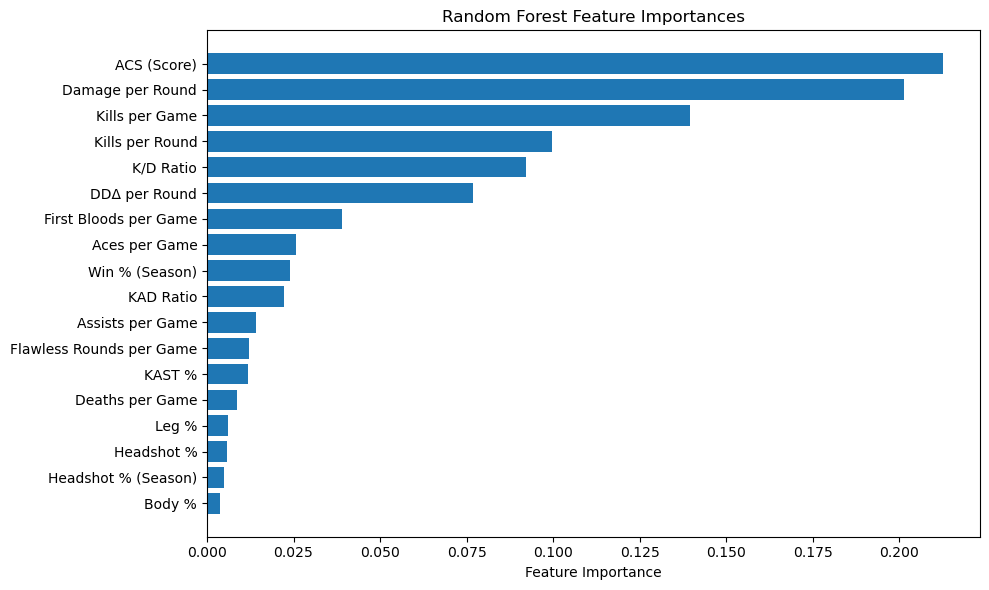

In [ ]:
importances = best_rf.feature_importances_
features = X_train.columns

# Clean display names for features
feature_name_map = {
    'hs_percent': 'Headshot %',
    'body_percent': 'Body %',
    'leg_percent': 'Leg %',
    's_damage_per_round': 'Damage per Round',
    's_kd_ratio': 'K/D Ratio',
    's_hs_percent': 'Headshot % (Season)',
    's_win_percent': 'Win % (Season)',
    's_kast_percent': 'KAST %',
    's_dd_round': 'DDΔ per Round',  # Delta Damage Per Round
    's_acs': 'ACS (Score)',
    's_kad_ratio': 'KAD Ratio',
    's_kills_per_round': 'Kills per Round',
    'deaths_per_game': 'Deaths per Game',
    'kills_per_game': 'Kills per Game',
    'assists_per_game': 'Assists per Game',
    'first_bloods_per_game': 'First Bloods per Game',
    'flawless_rounds_per_game': 'Flawless Rounds per Game',
    'aces_per_game': 'Aces per Game'
}

# Use the mapping to clean feature names
readable_features = [feature_name_map.get(col, col) for col in features]

import pandas as pd

feat_df = pd.DataFrame({
    'Feature': readable_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
